In [6]:
import sys
import os
# Get the absolute path to the project directory
project_dir = os.path.abspath("..")

# Append the project directory to sys.path
if project_dir not in sys.path:
    sys.path.append(project_dir)
    
from src.predictionModule.LoadupSamples import LoadupSamples

import pandas as pd
import numpy as np
import polars as pl
import datetime
import seaborn as sns
import lightgbm as lgb
import random
import matplotlib.pyplot as plt
import logging
import time
import re

In [7]:
df = pl.read_parquet("./notebook-analysis_df_11aug25_1116.parquet")
df.columns


['end_train_date',
 'end_test_date',
 'analysis_time',
 'res_meanmean',
 'res_toplast',
 'res_meanlast',
 'n_entries',
 'pred_toplast',
 'pred_meanmean',
 'pred_meanlast']

In [8]:
out =  (
    df.sort("pred_meanmean")
      .with_columns(
          tail_mean_return = (
              pl.col("res_meanmean").cum_sum(reverse=True) /
              pl.arange(1, pl.len() + 1).reverse()
          )
      )
)

In [9]:
out2 =  (
    df.sort("end_train_date")
      .with_columns(
          tail_pred_return = (
              pl.col("pred_meanmean").cum_sum(reverse=True) /
              pl.arange(1, pl.len() + 1).reverse()
          )
      )
)

In [10]:
out3 =  (
    df.sort("end_train_date")
      .with_columns(
          tail_pred_return = (
              pl.col("pred_meanmean").cum_sum(reverse=True) /
              pl.arange(1, pl.len() + 1).reverse()
          )
      )
)

In [11]:
out4 =  (
    df.sort("end_train_date")
      .with_columns(
          roll_mean_return = pl.col("res_meanmean").rolling_mean(window_size=40, min_samples=1, center=False)
          )# Adjust window size as needed
)

In [12]:
out5 = (
    df.filter(pl.col("pred_meanmean") > pl.quantile("pred_meanmean", 0.3))
    .sort("end_train_date")
    .with_columns(
        roll_mean_return = pl.col("res_meanmean").rolling_mean(window_size=10, min_samples=1, center=False)
    )# Adjust window size as needed
)

print(df.filter(pl.col("pred_meanmean") > pl.quantile("pred_meanmean", 0.3)).select("res_meanmean").mean())

shape: (1, 1)
┌──────────────┐
│ res_meanmean │
│ ---          │
│ f64          │
╞══════════════╡
│ 1.032158     │
└──────────────┘


In [31]:
out6 = (
    df.filter(pl.col("pred_meanlast") > pl.quantile("pred_meanlast", 0.7))
    .sort("end_train_date")
    .with_columns(
        roll_mean_return = pl.col("res_meanlast").rolling_mean(window_size=10, min_samples=1, center=False)
    )# Adjust window size as needed
)

for i in np.linspace(0, 1, 11):
    print(f"Quantile {i:<.1f}: {np.quantile(df['pred_meanlast'], i)}")
    
for i in np.linspace(0.01, 0.99, 11):
    q = np.quantile(df['pred_meanlast'], i)
    q_mean = df.filter(pl.col("pred_meanlast") > q).select("res_meanlast").mean().item()
    res = q_mean ** (52*(1-i))
    print(f"i = {i: <.2f}, q_mean = {q_mean}, res = {res}")

Quantile 0.0: 1.0001306213121046
Quantile 0.1: 1.0021176263263523
Quantile 0.2: 1.0032016612338732
Quantile 0.3: 1.0047904463790978
Quantile 0.4: 1.0061270742712485
Quantile 0.5: 1.0071189045524214
Quantile 0.6: 1.0079630110431397
Quantile 0.7: 1.0087402653568829
Quantile 0.8: 1.009645321735953
Quantile 0.9: 1.0126950634250258
Quantile 1.0: 1.0224824197139188
i = 0.01, q_mean = 1.0083975240853764, res = 1.538025566655331
i = 0.11, q_mean = 1.0118216358312324, res = 1.7248135688227015
i = 0.21, q_mean = 1.0145427171584378, res = 1.815054629884649
i = 0.30, q_mean = 1.0192819650107754, res = 1.996129677443578
i = 0.40, q_mean = 1.0190595446986874, res = 1.7987613592073843
i = 0.50, q_mean = 1.0301355074597838, res = 2.163980197248185
i = 0.60, q_mean = 1.0333590777141417, res = 1.9856756822988395
i = 0.70, q_mean = 1.046758753390189, res = 2.059373279970005
i = 0.79, q_mean = 1.0409610833736476, res = 1.5372988253919369
i = 0.89, q_mean = 1.0560202708897357, res = 1.358136380821894
i = 0

(array([19723., 19783., 19844., 19905., 19967., 20028., 20089., 20148.,
        20209., 20270.]),
 [Text(19723.0, 0, '2024-01'),
  Text(19783.0, 0, '2024-03'),
  Text(19844.0, 0, '2024-05'),
  Text(19905.0, 0, '2024-07'),
  Text(19967.0, 0, '2024-09'),
  Text(20028.0, 0, '2024-11'),
  Text(20089.0, 0, '2025-01'),
  Text(20148.0, 0, '2025-03'),
  Text(20209.0, 0, '2025-05'),
  Text(20270.0, 0, '2025-07')])

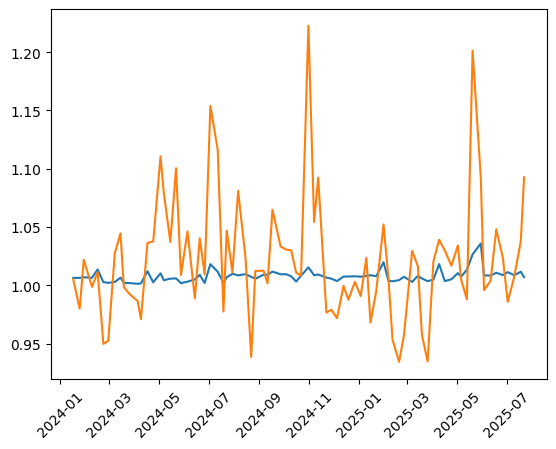

In [13]:
plt.plot(df['end_train_date'], df["pred_meanmean"], label="Mean Pred")
plt.plot(df['end_train_date'], (df["res_meanmean"]), label="Mean Return")
plt.xticks(rotation=45)